In [1]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline
%load_ext autoreload
%autoreload 2

# this line ensures that all models will have the same split
np.random.seed(1882)

In [2]:
XY = np.loadtxt('phishing.data', delimiter=',')
XY = XY.astype(np.int8)

In [3]:
from src.utilz import get_random_splits

datasets = get_random_splits(XY, [0.6, 0.2, 0.2], T = 10)

In [4]:
from src.tree import DecisionTree

tree = DecisionTree(no_features=30, max_depth=1, min_samples_split=2)

tree.fit(datasets[0][0][:, :-1], datasets[0][0][:, -1].reshape(-1, 1))

In [5]:
tree_train_error = tree.zero_one_error(datasets[0][0][:, :-1], datasets[0][0][:, -1].reshape(-1, 1))
tree_val_error = tree.zero_one_error(datasets[0][1][:, :-1], datasets[0][1][:, -1].reshape(-1, 1))
print(f"Training error: {tree_train_error:.4f}")
print(f"Validation error: {tree_val_error:.4f}")
print(f"The most important feature is x{tree.root.feature} with a threshold of {tree.root.threshold}")

Training error: 0.1080
Validation error: 0.1181
The most important feature is x25 with a threshold of 0.0


Stało się coś niesamowitego.  
Drzewo decyzyjne o głębokości 1 daje lepsze wyniki niż 2 poprzednie modele.  
Co więcej potwierdza się, że x25 jest najbardziej istotna.
Szczerze nie wiem co z tym zrobić. Liczyłem, że teraz klepnę las i on poprawi wyniki drzew, ale nie ma co poprawiać, pewnie wystarczy zwiększyć głębokość i będzie naprawdę bardzo dobrze.  
Gorsze niż to jest, że wyrzucenie cech powodowało katastrofę w SVM.  
Być może taka specyfika danych. Ale nie, przecież to znaczy, że dane są praktycznie liniowo separowalne.

In [6]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

sk_svm = SVC()
sk_svm.fit(datasets[0][0][:,25].reshape(-1, 1), datasets[0][0][:, -1])
y_pred = sk_svm.predict(datasets[0][1][:,25].reshape(-1, 1))
print(f'Reduced feature set accuracy: {accuracy_score(datasets[0][1][:, -1], y_pred)}')


Reduced feature set accuracy: 0.8819004524886878


Potwierdziło się

In [7]:
from src.tree import DecisionTree
from src.measures import average_error_val

tree1 = DecisionTree(no_features=30, max_depth=1, min_samples_split=2)
tree2 = DecisionTree(no_features=30, max_depth=8, min_samples_split=2)
tree3 = DecisionTree(no_features=30, max_depth=16, min_samples_split=2)

tree1_val_error, _ = average_error_val(tree1, datasets)
tree2_val_error, _ = average_error_val(tree2, datasets)
tree3_val_error, _ = average_error_val(tree3, datasets)

print(f"Average validation error for DT with max_depth=1:  {tree1_val_error}")
print(f"Average validation error for DT with max_depth=8:  {tree2_val_error}")
print(f"Average validation error for DT with max_depth=16: {tree3_val_error}")


Average validation error for DT with max_depth=1:  0.11113122171945704
Average validation error for DT with max_depth=8:  0.06447963800904978
Average validation error for DT with max_depth=16: 0.043846153846153854


Zostawię min_samples_split=2, wydaje mi się, że max_depth załatwi sprawę  
Nie schodzę z głębokością niżej

In [8]:
from src.tree import DecisionTree
from src.measures import average_error

tree = DecisionTree(no_features=30, max_depth=16, min_samples_split=2)
tree_error, tree_train_error = average_error(tree, datasets)

print(f"Average training error for DT with max_depth=16: {tree_train_error}")
print(f"Average test error for DT with max_depth=16: {tree_error}")

Average training error for DT with max_depth=16: 0.012861881785283474
Average test error for DT with max_depth=16: 0.046723904202440124


To jest powolne, bo za bardzo nie mamy jak wcisnąć tam numpy - 18.5s

In [9]:
print(F"Number of leaf nodes: {tree.get_number_of_leaves()}")

Number of leaf nodes: 363


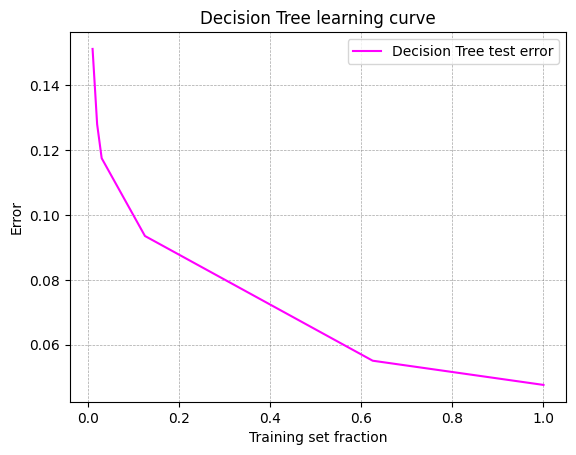

In [10]:
from src.measures import draw_learning_curve

training_set_fractions = [0.01, 0.02, 0.03, 0.125, 0.625, 1]

tree.reset()

draw_learning_curve([tree], datasets, training_set_fractions, ['magenta'])
